In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
path_modern = "/lus/h2resw01/hpcperm/ccpd/ECE4-DATA/nemo"
path_eocene = "/perm/itas/data/deepMIP/Herold_etal_2014"

In [3]:
topo_eocene = xr.open_dataset(f"{path_eocene}/herold_etal_eocene_topo_1x1.nc")
domain_modern = xr.open_dataset(f"{path_modern}/domain/ORCA1/domain_cfg.nc")

In [4]:
iwm_modern = xr.open_dataset(f"{path_modern}/initial/zdfiwm_forcing_r720x360.nc")
iwm_eocene = xr.open_dataset(f"{path_eocene}/Green_Huber_eocene_tidal_dissipation_1x1.nc")

In [5]:
topo_eocene['bathymetry'] = -topo_eocene['topo'].where(topo_eocene['topo'] < 0)

Text(0.5, 0, 'bathymetry [m]')

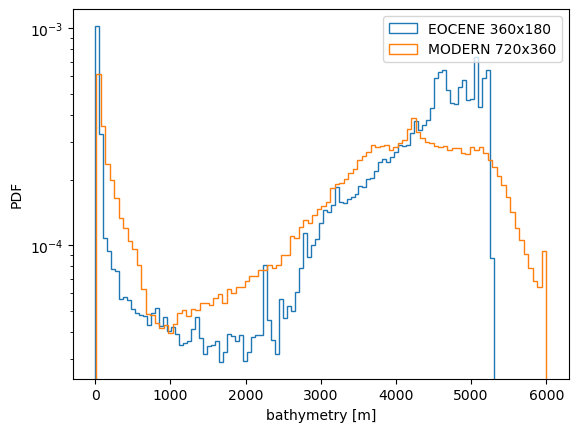

In [8]:
plt.hist(topo_eocene['bathymetry'].values.flatten(), density=True, bins=100, histtype="step", label='EOCENE 360x180')
plt.hist(iwm_modern['bathymetry'].values.flatten(), density=True, bins=100, histtype="step", label='MODERN 720x360')
plt.yscale('log')
plt.legend(loc="upper right")
plt.ylabel('PDF')
plt.xlabel('bathymetry [m]')

In [37]:
#iwm_modern['mask'] = iwm_modern['bathymetry'].where(iwm_modern['bathymetry'].isnull(), 1)
#iwm_modern['tidal_dissipation'] = iwm_modern['mask'] * (iwm_modern['power_bot']+iwm_modern['power_cri']+iwm_modern['power_nsq']+iwm_modern['power_sho'])

iwm_modern['mask'] = iwm_modern['bathymetry'].where(iwm_modern['bathymetry'].isnull(), 1)
comps = ['power_bot', 'power_cri', 'power_nsq', 'power_sho']
iwm_modern['tidal_dissipation'] = (
    iwm_modern['mask'] *
    iwm_modern[comps].to_array().sum("variable")
)

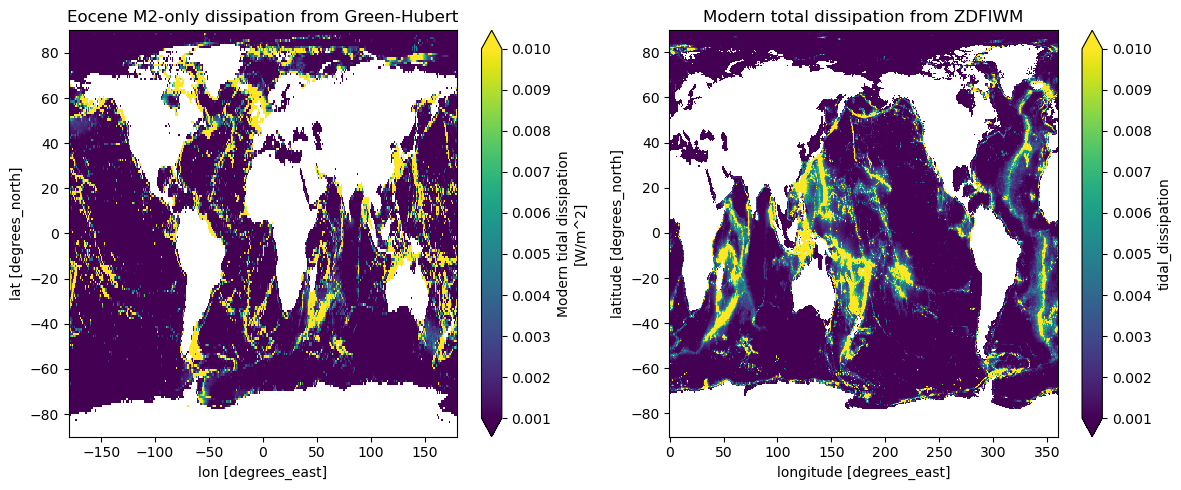

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
iwm_eocene['mod_tidal_dissipation'].plot(ax=axes[0], vmin=0.001, vmax=0.01)
axes[0].set_title("Eocene M2-only dissipation from Green-Huber")
iwm_modern['tidal_dissipation'].plot(ax=axes[1], vmin=0.001, vmax=0.01)
axes[1].set_title("Modern total dissipation from ZDFIWM")
plt.tight_layout()

In [26]:
iwm_eocene_remap = xr.open_dataset("/perm/itas/data/nemo/iwm/eocene_tidal_dissipation_r360x180.nc")
iwm_modern_remap = xr.open_dataset("/perm/itas/data/nemo/iwm/zdfiwm_forcing_r360x180.nc")

In [31]:
iwm_modern_remap['mask'] = iwm_modern_remap['bathymetry'].where(iwm_modern_remap['bathymetry'].isnull(), 1)
comps = ['power_bot', 'power_cri', 'power_nsq', 'power_sho']
iwm_modern_remap['tidal_dissipation'] = (
    iwm_modern_remap['mask'] *
    iwm_modern_remap[comps].to_array().sum("variable")
)

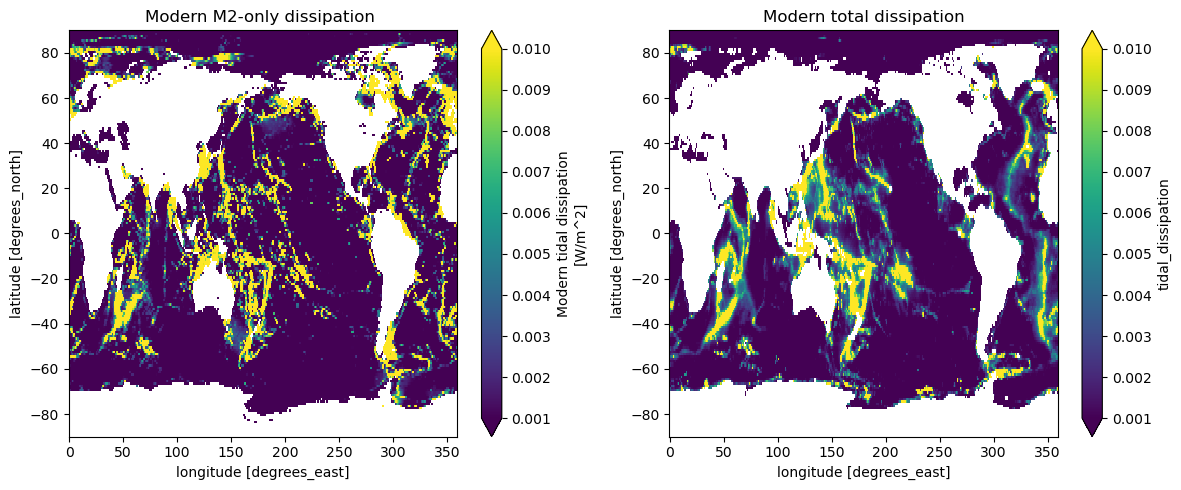

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
iwm_eocene_remap['mod_tidal_dissipation'].plot(ax=axes[0], vmin=0.001, vmax=0.01)
axes[0].set_title("Modern M2-only dissipation ")
iwm_modern_remap['tidal_dissipation'].plot(ax=axes[1], vmin=0.001, vmax=0.01)
axes[1].set_title("Modern total dissipation")
plt.tight_layout()

Text(0.5, 0, 'tidal dissipation difference [W/m^2]')

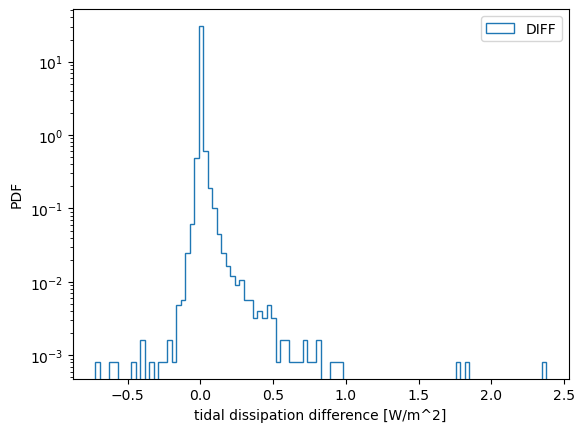

In [36]:
diff = (iwm_eocene_remap['mod_tidal_dissipation'] - iwm_modern_remap['tidal_dissipation'])
plt.hist(diff.values.flatten(), density=True, bins=100, histtype="step", label='DIFF')
plt.yscale('log')
plt.legend(loc="upper right")
plt.ylabel('PDF')
plt.xlabel('tidal dissipation difference [W/m^2]')

Text(0.5, 0, 'tidal dissipation [W/m^2]')

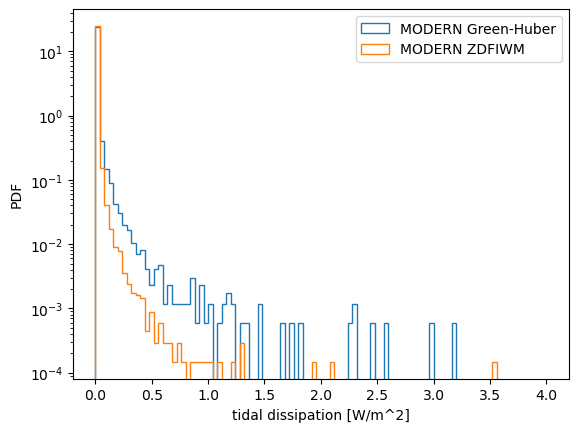

In [109]:
plt.hist(iwm_eocene['mod_tidal_dissipation'].values.flatten(), density=True, bins=100, histtype="step", range=[0.0, 4.0], label='MODERN Green-Huber')
plt.hist(iwm_modern['tidal_dissipation'].values.flatten(), density=True, bins=100, histtype="step", range=[0.0, 4.0], label='MODERN ZDFIWM')
plt.yscale('log')
plt.legend(loc="upper right")
plt.ylabel('PDF')
plt.xlabel('tidal dissipation [W/m^2]')

Text(0.5, 0, 'tidal dissipation [W/m^2]')

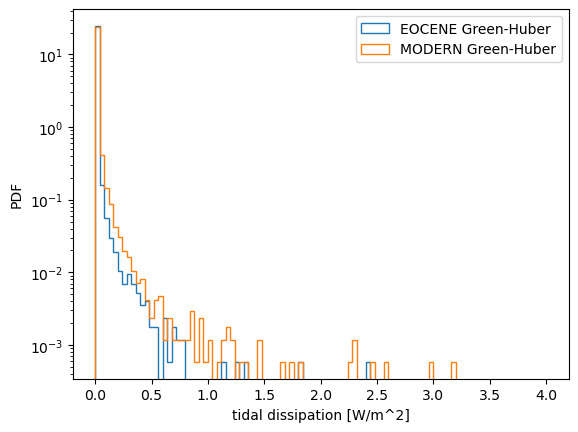

In [108]:
plt.hist(iwm_eocene['eo_tidal_dissipation'].values.flatten(), density=True, bins=100, range=[0.0, 4.0], histtype="step", label='EOCENE Green-Huber')
plt.hist(iwm_eocene['mod_tidal_dissipation'].values.flatten(), density=True, bins=100, range=[0.0, 4.0], histtype="step", label='MODERN Green-Huber')
plt.yscale('log')
plt.legend(loc="upper right")
plt.ylabel('PDF')
plt.xlabel('tidal dissipation [W/m^2]')

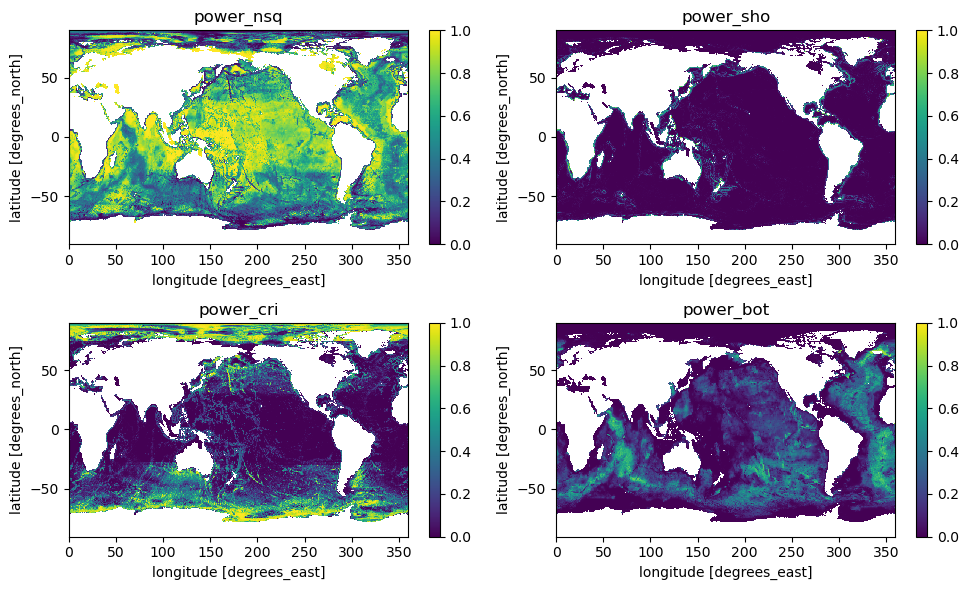

In [96]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
(iwm_modern['mask']*iwm_modern['power_nsq']/iwm_modern['tidal_dissipation']).plot(ax=axes[0][0], vmin=0.0, vmax=1.0)
axes[0][0].set_title("power_nsq")
(iwm_modern['mask']*iwm_modern['power_sho']/iwm_modern['tidal_dissipation']).plot(ax=axes[0][1], vmin=0.0, vmax=1.0)
axes[0][1].set_title("power_sho")
(iwm_modern['mask']*iwm_modern['power_cri']/iwm_modern['tidal_dissipation']).plot(ax=axes[1][0], vmin=0.0, vmax=1.0)
axes[1][0].set_title("power_cri")
(iwm_modern['mask']*iwm_modern['power_bot']/iwm_modern['tidal_dissipation']).plot(ax=axes[1][1], vmin=0.0, vmax=1.0)
axes[1][1].set_title("power_bot")
plt.tight_layout()

Text(0, 0.5, 'bot')

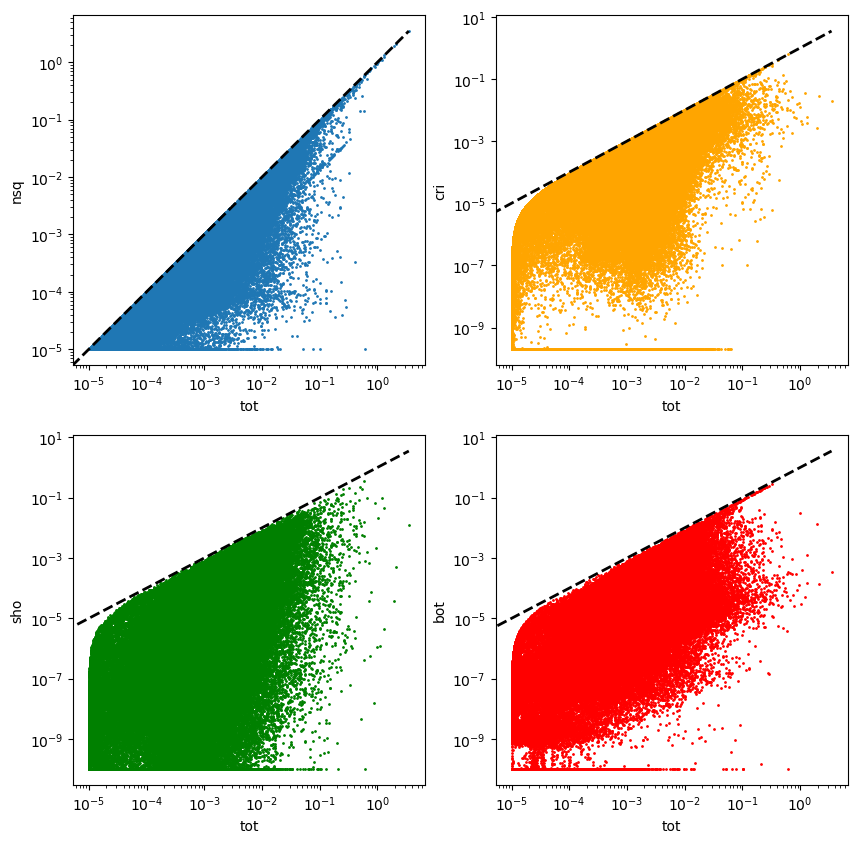

In [211]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

x = np.linspace(0, 3.5, 100)
y = x
axes[0][0].plot(x, y, linewidth=2, label="x", ls='--', color='black')
axes[0][0].scatter(iwm_modern['tidal_dissipation'],iwm_modern['power_nsq'], s=1, label='nsq')
axes[0][0].set_yscale('log')
axes[0][0].set_xscale('log')
axes[0][0].set_xlabel('tot')
axes[0][0].set_ylabel('nsq')

axes[1][0].plot(x, y, linewidth=2, label="x", ls='--', color='black')
axes[1][0].scatter(iwm_modern['tidal_dissipation'],iwm_modern['power_sho'], label='sho', s=1, color='green')
axes[1][0].set_yscale('log')
axes[1][0].set_xscale('log')
axes[1][0].set_xlabel('tot')
axes[1][0].set_ylabel('sho')

axes[0][1].plot(x, y, linewidth=2, label="x", ls='--', color='black')
axes[0][1].scatter(iwm_modern['tidal_dissipation'],iwm_modern['power_cri'], label='cri', s=1, color='orange')
axes[0][1].set_yscale('log')
axes[0][1].set_xscale('log')
axes[0][1].set_xlabel('tot')
axes[0][1].set_ylabel('cri')

axes[1][1].plot(x, y, linewidth=2, label="x", ls='--', color='black')
axes[1][1].scatter(iwm_modern['tidal_dissipation'],iwm_modern['power_bot'], label='bot', s=1, color='red')
axes[1][1].set_yscale('log')
axes[1][1].set_xscale('log')
axes[1][1].set_xlabel('tot')
axes[1][1].set_ylabel('bot')


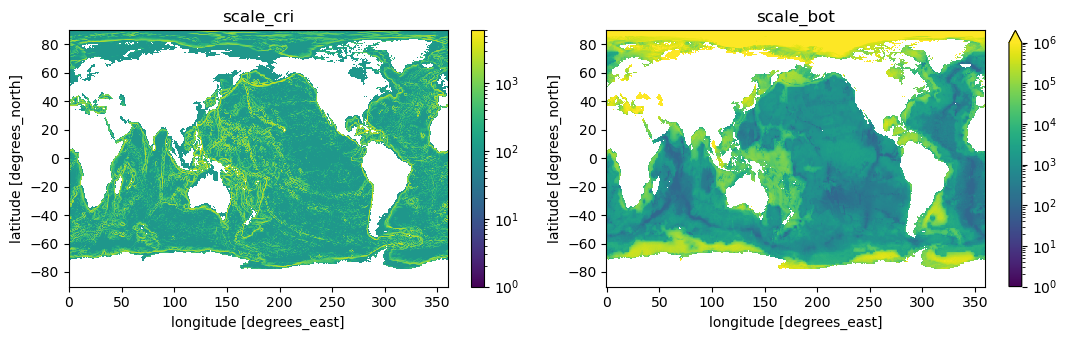

In [136]:
import matplotlib.colors as colors

fig, axes = plt.subplots(1, 2, figsize=(11, 3.5))
(iwm_modern['mask'] * iwm_modern['scale_cri']).plot(ax=axes[0], norm=colors.LogNorm(vmin=1, vmax=6000))
axes[0].set_title("scale_cri")
(iwm_modern['mask'] * iwm_modern['scale_bot']).plot(ax=axes[1], norm=colors.LogNorm(vmin=1, vmax=1e6))
axes[1].set_title("scale_bot")
plt.tight_layout()

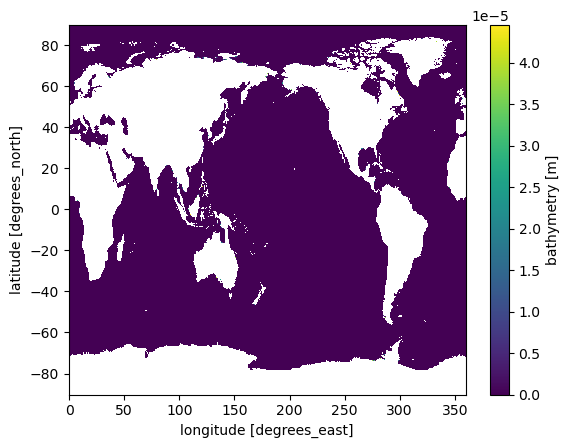

In [147]:
gg = np.exp(-iwm_modern['bathymetry'])
gg.plot()
#plt.hist(gg, density=True, bins=100, histtype="step", label='bathy')

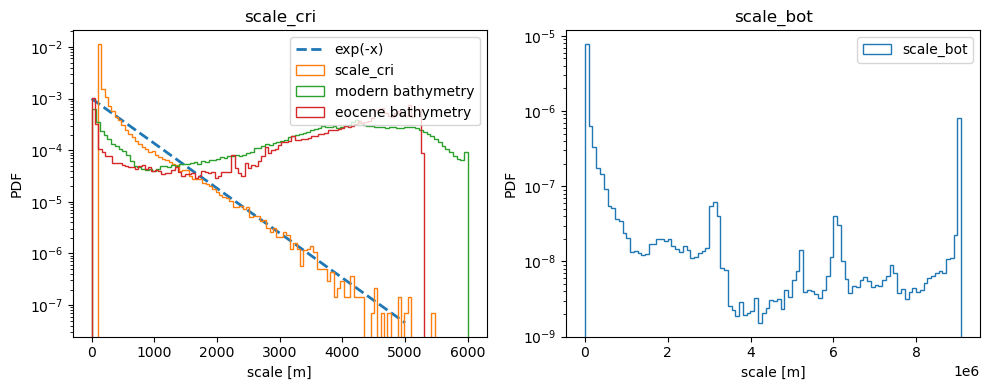

In [155]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

x = np.linspace(0, 5000, 100)
y = 0.001*np.exp(-x/500)
axes[0].plot(x, y, linewidth=2, label="exp(-x)", ls='--')
axes[0].hist(iwm_modern['scale_cri'].values.flatten(), density=True, bins=100, histtype="step", label='scale_cri')
axes[0].hist(iwm_modern['bathymetry'].values.flatten(), density=True, bins=100, histtype="step", label='modern bathymetry')
axes[0].hist(topo_eocene['bathymetry'].values.flatten(), density=True, bins=100, histtype="step", label='eocene bathymetry')
axes[0].set_title("scale_cri")
axes[0].set_yscale('log')
axes[0].set_ylabel('PDF')
axes[0].set_xlabel('scale [m]')
axes[0].legend(loc="upper right")

axes[1].hist(iwm_modern['scale_bot'].values.flatten(), density=True, bins=100, histtype="step", label='scale_bot')
axes[1].set_title("scale_bot")
axes[1].set_yscale('log')
axes[1].set_ylabel('PDF')
axes[1].set_xlabel('scale [m]')
axes[1].legend(loc="upper right")

plt.tight_layout()


In [171]:
iwm_modern['bathymetry'].min()

<xarray.DataArray 'bathymetry' ()> Size: 8B
array(10.01889107)

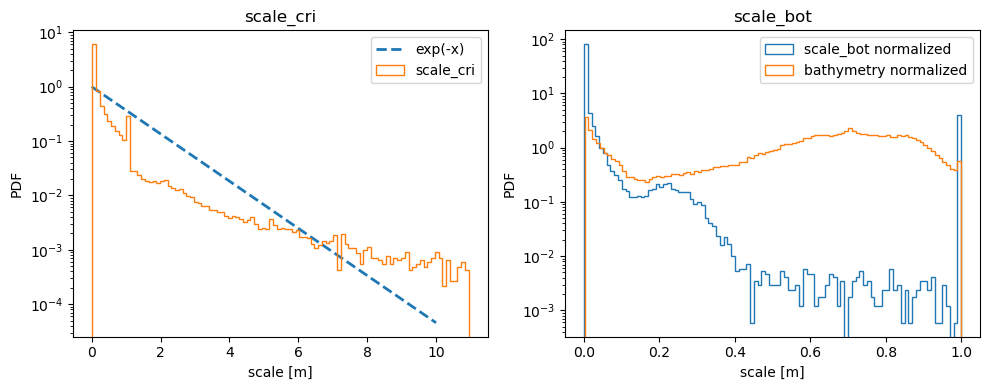

In [174]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

x = np.linspace(0, 10, 100)
y = np.exp(-x)
axes[0].plot(x, y, linewidth=2, label="exp(-x)", ls='--')
ratio1 = iwm_modern['mask'] * (iwm_modern['scale_cri']/iwm_modern['scale_cri'].max())/(iwm_modern['bathymetry']/iwm_modern['bathymetry'].max())
axes[0].hist(ratio1.values.flatten(), density=True, bins=100, histtype="step", label='scale_cri')
axes[0].set_title("scale_cri")
axes[0].set_yscale('log')
axes[0].set_ylabel('PDF')
axes[0].set_xlabel('scale [m]')
axes[0].legend(loc="upper right")

ratio2 = iwm_modern['mask'] * (iwm_modern['scale_bot']/iwm_modern['scale_bot'].max())
ratio3 = iwm_modern['mask'] * (iwm_modern['bathymetry']/iwm_modern['bathymetry'].max())
axes[1].hist(ratio2.values.flatten(), density=True, bins=100, histtype="step", label='scale_bot normalized')
axes[1].hist(ratio3.values.flatten(), density=True, bins=100, histtype="step", label='bathymetry normalized')
axes[1].set_title("scale_bot")
axes[1].set_yscale('log')
axes[1].set_ylabel('PDF')
axes[1].set_xlabel('scale [m]')
axes[1].legend(loc="upper right")

plt.tight_layout()

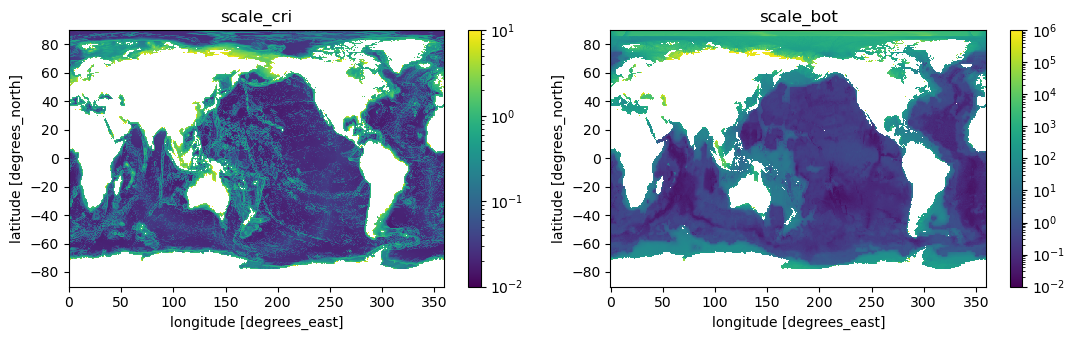

In [134]:
import matplotlib.colors as colors

fig, axes = plt.subplots(1, 2, figsize=(11, 3.5))
(iwm_modern['mask'] * iwm_modern['scale_cri']/iwm_modern['bathymetry']).plot(ax=axes[0], norm=colors.LogNorm(vmin=1e-2, vmax=10))
axes[0].set_title("scale_cri")
(iwm_modern['mask'] * iwm_modern['scale_bot']/iwm_modern['bathymetry']).plot(ax=axes[1], norm=colors.LogNorm(vmin=1e-2, vmax=1e6))
axes[1].set_title("scale_bot")
plt.tight_layout()